# Compare MWAS methods for sanity tests and troubleshooting

In version e, we unify the elastic.net functions and make sure 1se and 1min produce different results.

In version f, we try old covariates with all new data for everything else

In version g, we do another quick sanity test with "all" sample methylation data instead of AA.

In version h, we try old covariates, new BSseq data, new everything else. Since we're using old BSseq data, we must change back to Chr 7 for the selected peak for which we have sample data. We got normal results!

In version i, change back to Chr 1 and see if we still get normal results.... We did not!

Ok, now let's try other chromosomes/regions with random sites (version l)

version m: add manhattan plots and MAF filter

version n: go back to region in Shizhong's `BSsample.rda` file

Down the road (o), let's change covariates back to ours

Also in o, we found that Shizhong's old results still don't quite match up with ours.

So now in p, we will use original BSsample and see if they finally do... In p, we still get different results.

Now in q, we use old covar in addition to old BSsample.

In r, we also use old SNPs. Ding ding ding, now we get approximately same results (although slightly different I guess due to stochasticity)

In s, we use new SNPs for reference population in stage 2, but old SNPs for LIBD in stage 1. We get different result again.

In t, we switch back to old reference population SNPs for stage 2

In u, we closely inspect Shizhong's snp.1kg.eur2 and compare it to ours. We discovered alleles are flipped differently for 10 SNPs and not the other 56.

In v, we do another sanity check where we use our re-created snp.1kg.eur2 made from PLINK files, but use the exact same 56 SNPs as in Shizhong's version. Of note, 10 of these don't match, only the other 46.

In w, see if it works if we simply flip the ones that don't match.

In [1]:
Sys.time()

[1] "2024-08-07 07:57:06 PDT"

In [2]:
chr <- 7 # code set up for old bsseq chr 7, or anything with new bsseq
maf <- 0.05

min_site_to_test_pos <- 1980077
max_site_to_test_pos <- 1989957

In [3]:
sites_to_test_pos <- "range"
#n_samples <- 500

In [4]:
# # Chr 1 sites
# sites_to_test_pos <- c(73274305, 73274312, 73292330, 73307769, 73308571, 73419188, 73419830, 73420076)

In [5]:
filter_snps <- FALSE # speed things up by pre-filtering whole chromosomes to desired regions

## Be ready with matched up SNP and covariate files

In [6]:
library("glmnet")
library("e1071")
library("doParallel")
library("data.table")

Loading required package: Matrix

Loaded glmnet 4.1-8

Loading required package: foreach

Loading required package: iterators

Loading required package: parallel



In [7]:
#df <- fread("09-OUT_matched_SNP_meth_cov_a2.csv")
df <- fread("12-OUT_matched_SNP_meth_cov_outputs.csv")

In [8]:
df <- df[which(df$Chr == chr), ]

In [9]:
getwd()

[1] "/expanse/lustre/projects/jhu152/naglemi/mwas/CpGWAS/scripts"

In [10]:
file <- readRDS(df[3, ]$path)

In [11]:
length(file@models)

[1] 20000

In [12]:
file@models[[20000]]

Loading required package: CpGWAS



An object of class "MethylationBase"
Slot "methylationPosition":
[1] 2026044

Slot "windowSize":
[1] 10000

Slot "n_SNPs":
[1] 55

Slot "glmnetModel":
NULL

Slot "snpWeights":
chr7:2033300:C:G chr7:2034492:A:G 
   -0.0078559433    -0.0009370443 

Slot "intercept":
         s0 
0.004475171 

Slot "alpha":
[1] 0.5

Slot "lambda":
[1] 0.005287147

Slot "evaluation_results":
         cor          mse 
7.085096e-01 8.962069e-05 

Slot "cv_eval_mode":
[1] "dynamic"

Slot "full_model_metrics":
           r          mse 
7.149548e-01 8.803695e-05 


In [13]:
file@models[[1]]

An object of class "MethylationBase"
Slot "methylationPosition":
[1] 1358612

Slot "windowSize":
[1] 10000

Slot "n_SNPs":
[1] 25

Slot "glmnetModel":
NULL

Slot "snpWeights":
chr7:1367786:T:C 
    1.152565e-17 

Slot "intercept":
          s0 
1.889452e-15 

Slot "alpha":
[1] 0.5

Slot "lambda":
[1] 0.01770665

Slot "evaluation_results":
         cor          mse 
-0.146055801  0.003099936 

Slot "cv_eval_mode":
[1] "dynamic"

Slot "full_model_metrics":
          r         mse 
0.160186613 0.003054643 


In [14]:
df <- df[which(df$population == "all"), ]
df <- df[which(df$region == "caud"), ]

In [15]:
i <- 1

In [16]:
df[1, ]

Chr,population,region,chunk_start,chunk_end,SNP_data,methylation_data,last_meth_value_with_SNP_coverage,first_meth_value_with_SNP_coverage,last_meth_index_with_SNP_coverage,first_meth_index_with_SNP_coverage,cov_file,modified_methylation_data,path
<int>,<chr>,<chr>,<int>,<dbl>,<chr>,<chr>,<int>,<int>,<int>,<int>,<chr>,<chr>,<chr>
7,all,caud,1,20000,/dcs04/lieber/statsgen/shizhong/michael/mwas/gwas//libd_chr7.pgen,/dcs04/lieber/statsgen/shizhong/michael/mwas/pheno/caud/out/chr7_all.rda,159334659,49742,1490198,1,/dcs04/lieber/statsgen/mnagle/mwas/full_covariates/all_caud.csv,/dcs04/lieber/statsgen/mnagle/mwas/pheno/caud/out/chr7_all_1-20000.rds,..//output_EXPANSE_a2_caud/libd_chr7-chr7_all-libd_chr7-chr7_all-1-20000-dynamic-1corestotal-allcorepera-20240422-125749.rds


In [17]:
set.seed(2018)
wind <- c(10000)
# output directory
#outd <- "/dcl02/lieber/shan/shizhong/finemapping/GWAS/tags/scz3/mwas/chr22/1/"
outd <- "20-OUT_original_mwas_sanity_test/"

## Functions

### Shizhong's original

In [18]:
###### model: learn elastic net model on training data 
######---------Input: trainX, trainY
######---------Return: selected features and coefficents

# original
# elastic.net <- function(trainX,trainY){
#     if(nrow(trainX)!=length(trainY)){
#             stop("Number of observations is differerent")
#     } 

#     # optimize alpha---mixing parameter  
#     a <- 0.5
#     search <- foreach(ai = a, .combine = rbind) %dopar% {
#         cv.fit <- cv.glmnet(
#                         trainX,
#                         trainY,
#                         nfold = 5,
#                         type.measure = "mse",
#                         paralle = TRUE,
#                         alpha = ai
#                         )
#         data.frame(
#                         cvm = min(cv.fit$cvm),
#                         lambda = cv.fit$lambda.min,
#                         alpha = ai
#                         )
#         } 
#     cv.opt <- search[search$cvm == min(search$cvm),] 

#         # fit model by optimized alpha and lambda
#         yfit = glmnet(
#         trainX,
#         trainY,
#         lambda = cv.opt$lambda,
#         alpha = cv.opt$alpha
#                 )       
#         idf <- coef(yfit)
#         idx <- which(idf != 0)
#         selectf <- data.frame(
#                 features = idf@Dimnames[[1]][idx], 
#                 coefs = idf [idx]
#         )
# }

MWAS <- function(gwas, weight, geno){
        z <- gwas %*% weight
        z.cor <- cor(geno)
        se <- sqrt(weight %*%  z.cor %*%  weight)
        z <- z/se
        p=pnorm(abs(z),lower.tail=F)*2
        return(c(z, p))
}

#### Modified `elastic.net` to use `lambda.1se`

In [19]:
# modified to use lambda 1se and appropriate cvm
elastic.net <- function(trainX,trainY, lambda.choice = "1se"){
    if(nrow(trainX)!=length(trainY)){
            stop("Number of observations is differerent")
    } 

    # optimize alpha---mixing parameter  
    a <- 0.5
    search <- foreach(ai = a, .combine = rbind) %dopar% {
        #set.seed(42)
        cv.fit <- cv.glmnet(
                        trainX,
                        trainY,
                        nfold = 5,
                        type.measure = "mse",
                        parallel = TRUE,
                        alpha = ai
                        )
        #print(paste0("Dim of trainX: ", dim(trainX)))
        #print(paste0("Len of trainY: ", length(trainY)))
        coef_matrix <- as.matrix(coef(cv.fit))

        if(lambda.choice == "1se"){
            chosen_lambda <- cv.fit$lambda.1se
            chosen_cvm <- cv.fit$cvm[cv.fit$lambda == cv.fit$lambda.1se]
        }
        if(lambda.choice == "min"){
            chosen_lambda <- cv.fit$lambda.min
            chosen_cvm <- min(cv.fit$cvm)
        }


        data.frame(
                        cvm = chosen_cvm,
                        lambda = chosen_lambda,
                        alpha = ai
                        )
        } 
    cv.opt <- search[search$cvm == min(search$cvm),] 

        # fit model by optimized alpha and lambda
    #set.seed(42)
    yfit <- glmnet(
    trainX,
    trainY,
    lambda = cv.opt$lambda,
    alpha = cv.opt$alpha)

    idf <- coef(yfit)
    idx <- which(idf != 0)
    selectf <- data.frame(
            features = idf@Dimnames[[1]][idx], 
            coefs = idf [idx]
    )
}

In [20]:
# version using for loop for easier debugging

elastic.net <- function(trainX, trainY, lambda.choice = "1se") {
    if (nrow(trainX) != length(trainY)) {
        stop("Number of observations is different")
    }

    a <- 0.5
    search <- NULL

    for (ai in a) {
        cv.fit <- cv.glmnet(
            trainX,
            trainY,
            nfold = 5,
            type.measure = "mse",
            parallel = FALSE,
            alpha = ai
        )
        coef_matrix <- as.matrix(coef(cv.fit))

        if (lambda.choice == "1se") {
            chosen_lambda <- cv.fit$lambda.1se
            chosen_cvm <- cv.fit$cvm[cv.fit$lambda == cv.fit$lambda.1se]
        }
        if (lambda.choice == "min") {
            chosen_lambda <- cv.fit$lambda.min
            chosen_cvm <- min(cv.fit$cvm)
        }

        search <- rbind(
            search,
            data.frame(
                cvm = chosen_cvm,
                lambda = chosen_lambda,
                alpha = ai
            )
        )
    }

    cv.opt <- search[search$cvm == min(search$cvm),]

    yfit <- glmnet(
        trainX,
        trainY,
        lambda = cv.opt$lambda,
        alpha = cv.opt$alpha
    )

    idf <- coef(yfit)
    idx <- which(idf != 0)
    selectf <- data.frame(
        features = idf@Dimnames[[1]][idx],
        coefs = idf[idx]
    )
}


## Replace all old objects with new objects in same format

### Methylation data

In [21]:
suppressWarnings(library(bsseq))

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:data.table’:

    first, second


The following objects are masked from ‘package:Matrix’:

    expand, unname


The following object is masked from ‘package:utils’:

    findMatches


The

In [22]:
# # # The code in this block is for NEW methylation data, which can be for any chromosome or portion

# # # load data for mwas
# # # load("./rda/caudate_mwas_data_chr22.rda")
# load(df$methylation_data[i])

# p <- getMeth(BSobj2)


# rownames(p) <- start(BSobj2)

# if(sites_to_test_pos[1] == "random"){
#     sites_to_test_pos <- sample(start(BSobj2), n_samples)
# } else {
#     sites_to_test_pos <- start(BSobj2)[which(start(BSobj2) >= min_site_to_test_pos & start(BSobj2) <= max_site_to_test_pos)]
# }

# sites_to_test <- which(start(BSobj2) %in% sites_to_test_pos)
# p <- p[sites_to_test, ]
# cg <- as.numeric(rownames(p))

In [23]:
# length(sites_to_test_pos)

In [24]:
# head(sites_to_test_pos)

Subset our p object to the same sites as the old one, compare values

In [25]:
# Old dataset
load("BSsample.rda", verbose = TRUE) # we get the @colData attribute as a data.frame here
load("p1.rda", verbose = TRUE) # and the p matrix from getMeth() here

BSobj2 <- BSsample
cg <- as.numeric(rownames(p)) # This line same whether we use old or new version
sites_to_test_pos <- cg

Loading objects:
  BSsample
Loading objects:
  snp.gwas2
  snp.1kg.eur2
  map.1kg.eur2
  snp2
  map2
  p
  BSsample


### covariates

In [26]:
# #The code in this block is for NEW covariate data

# covs <- fread(df$cov_file[i])
# covs <- t(covs)
# colnames(covs) <- covs[1, ]
# covs <- covs[2:nrow(covs), ]
# # transpose so we have same orientation as original code

In [27]:
# This is the OLD covariate data

load("covs_for_meqtl.rda")

### Regress methylation data over covariates

In [28]:
BSobj2$brnum <- gsub("Br0", "Br", BSobj2$brnum)
colnames(covs) <- gsub("Br0", "Br", colnames(covs))

In [29]:
mat <- match(BSobj2$brnum,colnames(covs)) 
covs <- t(covs[,mat])
p.residual=matrix(NA,dim(p)[1],dim(p)[2])

In [30]:
# This is something we only need to do for new covariates
if("genoPC1" %in% colnames(covs)){
    rownames(covs)[is.na(covs[, 'genoPC1'])] <- BSobj2$brnum[is.na(covs[, 'genoPC1'])]
}

In [31]:
colnames(p.residual) <- BSobj2$brnum

In [32]:
covs <- as.data.frame(covs)
# Convert all columns except Dx and Sex from character to numeric
cols_to_convert <- setdiff(names(covs), c("Dx", "Sex"))

for (col in cols_to_convert) {
  covs[[col]] <- as.numeric(covs[[col]])
}

# Print the modified data frame to check the conversion
#print(dat)


In [33]:
for (i in 1:dim(p)[1]) { # For each methylation site
    dat <- as.data.frame(cbind(y = p[i,], covs))
    
    # Check for rows with NAs (the ones for which we don't have covariate data)
    valid_rows <- complete.cases(dat)
    
    if (sum(valid_rows) > 0) {
        dat_valid <- dat[valid_rows,]
        model.res <- lm(y ~ ., data = dat_valid)
        
        # Store residuals in the corresponding positions
        p.residual[i, valid_rows] <- resid(model.res)
    }
}


# for(i in 1:dim(p)[1]){ # foro each methylation site
#         dat <- as.data.frame(cbind(p[i,],covs))
#         colnames(dat) <- c("y",paste0("x",1:ncol(covs)))
#         model.res <- lm(reformulate(paste0("x",1:ncol(covs)), "y"),dat)
#         p.residual[i,] = resid(model.res) 
# }

In [34]:
dim(p.residual)

[1] 330 308

In [35]:
p.residual[1:8, 1:8]

Br836,Br845,Br848,Br863,Br914,Br948,Br949,Br963
0.01273526,0.003955796,-0.006492196,-0.003937108,-0.003108317,-0.02635100,-0.01780211,0.02198214
0.01244238,0.004791327,-0.006684356,-0.004304248,-0.002787528,-0.02590003,-0.01859511,0.02199029
0.01199289,0.005968815,-0.006910408,-0.004612377,-0.002502153,-0.02531498,-0.01932406,0.02187912
0.01185321,0.006292368,-0.006985009,-0.004655232,-0.002462299,-0.02516852,-0.01943433,0.02181896
0.01165765,0.006722936,-0.007091745,-0.004689633,-0.002431018,-0.02498177,-0.01953200,0.02172186
0.01077923,0.008466136,-0.007601638,-0.004627312,-0.002500745,-0.02429218,-0.01948105,0.02116477
0.01066253,0.008680782,-0.007672761,-0.004601013,-0.002526803,-0.02421065,-0.01943371,0.02108082
0.01035960,0.009223814,-0.007860604,-0.004518253,-0.002606966,-0.02400573,-0.01927932,0.02085531


In [36]:
sum(is.na(p.residual))

[1] 0

In [37]:
sum(rowSums(is.na(p.residual)) == ncol(p.residual))
sum(colSums(is.na(p.residual)) == nrow(p.residual))

[1] 0

[1] 0

In [38]:
# p.residual <- p.residual[, colSums(is.na(p.residual)) != nrow(p.residual)]

In [39]:
sum(is.na(p.residual))

[1] 0

In [40]:
snp.gwas2 <- NULL

In [41]:
#load("p1.rda", verbose = TRUE)

### summary stats

In [42]:
library(data.table)
library(CpGWAS)

In [43]:
ss_path <- "/home/naglemi/mwas/gwas/gwas_stat_scz"

In [44]:
snp.gwas2 <- fread(ss_path, skip = 1, header = FALSE)
colnames(snp.gwas2) <- strsplit(readLines(ss_path, n = 1), "\t")[[1]]

In [45]:
snp.gwas2$z <- log(snp.gwas2$OR)/snp.gwas2$SE

In [46]:
snp.gwas2 <- snp.gwas2[, c(2, 1, 3, 3, 8, 4, 5, 20, 11)]

In [47]:
head(snp.gwas2, n = 1)

SNP,CHR,BP,BP,INFO,A1,A2,z,P
<chr>,<int>,<int>,<int>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
rs62513865,8,100579985,100579985,0.963,C,T,0.7016221,0.4847


In [48]:
colnames(snp.gwas2)[1:5] <- c("snp", "chr", "pos_hg38", "pos_hg38", "info")

In [49]:
CHR <- chr # to avoid R df local env mixing variables of columns name and subset variable

In [50]:
snp.gwas2 <- snp.gwas2[which(snp.gwas2$chr == CHR), ]

In [51]:
if(filter_snps == TRUE){
    snp.gwas2 <- snp.gwas2[which(snp.gwas2$pos_hg38 >= (min(sites_to_test_pos)-10000) & snp.gwas2$pos_hg38 <= (max(sites_to_test_pos) + 10000)), ]
}

In [52]:
snp.gwas2 <- snp.gwas2[order(snp.gwas2$pos_hg38), ]

In [53]:
head(BSobj2)

DataFrame with 6 rows and 10 columns
               ID       brnum has_genotype   source  agedeath      sex     race
      <character> <character>    <logical> <factor> <numeric> <factor> <factor>
1 LIBD1633_190509       Br836         TRUE       DC     20.77        M       AA
2 LIBD1654_190509       Br845         TRUE       DC     24.79        M       AA
3 LIBD1508_190509       Br848         TRUE       DC     22.71        M       AA
4 LIBD1655_190509       Br863         TRUE       DC     43.85        M       AA
5 LIBD1604_190509       Br914         TRUE       DC     19.69        F       AA
6 LIBD1389_190509       Br948         TRUE       DC     45.91        M       AA
  primarydx       pmi        ph
   <factor> <numeric> <numeric>
1   Control      25.5      6.46
2   Control      43.5      6.94
3   Control      38.5      6.57
4   Control      24.5      6.57
5   Control      19.0      6.98
6   Control      38.5      6.66

In [54]:
dim(BSobj2)

[1] 308  10

In [55]:
BSobj2 <- BSobj2[which(BSobj2$brnum %in% colnames(p.residual)), ]

In [56]:
dim(BSobj2)

[1] 308  10

In [57]:
# built predition models
idx.ea <- BSobj2$race == "CAUC"

In [58]:
levels(factor(snp.gwas2$chr))

[1] "7"

### SNPs in LIBD population

#### Old dataset

#### New dataset prep: For reference, first load Shizhong's formatted SNPs on Chr7

In [59]:
load("p1.rda", verbose = TRUE)

snp2_sorted <- snp2[, order(names(snp2))]

colnames(snp2) <- gsub("Br0", "Br", colnames(snp2))

snp2 <- snp2[, colnames(snp2) %in% colnames(p.residual)]

snp2_positions <- stringr::str_split_fixed(rownames(snp2), ":", 3)[, 2]

snp3 <- snp2
map3 <- map2

Loading objects:
  snp.gwas2
  snp.1kg.eur2
  map.1kg.eur2
  snp2
  map2
  p
  BSsample


#### New dataset: Now let's load ours on Chr1

In [60]:
# paths <- list(
#   pvar_path = paste0("/expanse/lustre/projects/jhu152/naglemi/mwas/gwas/libd_chr", chr, ".pvar"),
#   pgen_path = paste0("/expanse/lustre/projects/jhu152/naglemi/mwas/gwas/libd_chr", chr, ".pgen"),
#   psam_path = paste0("/expanse/lustre/projects/jhu152/naglemi/mwas/gwas/libd_chr", chr, ".psam")
# )

# my_SNPs <- loadSNPData(paths$pvar_path, paths$pgen_path, paths$psam_path)

In [61]:
# filter_snps <- TRUE

In [62]:
# if(filter_snps == TRUE){
#     snp_indices_of_interest <- which(my_SNPs$pvar_dt$POS >= min(sites_to_test_pos)-100000 & my_SNPs$pvar_dt$POS <= max(sites_to_test_pos) + 100000)
# }

In [63]:
# if(filter_snps == TRUE){
#     snp3 <- pgenlibr::ReadList(my_SNPs$pgen,
#                                variant_subset = snp_indices_of_interest)
#     colnames(snp3) <- my_SNPs$pvar_dt$ID[snp_indices_of_interest]
# } else {
#     snp3 <- pgenlibr::ReadList(my_SNPs$pgen)
#     colnames(snp3) <- my_SNPs$pvar_dt$ID
# }

In [64]:
# snp3[1:10, 1:10]

In [65]:
# rownames(snp3) <- my_SNPs$psam$`#IID`

filter by `maf`

In [66]:
# dim(snp3)

In [67]:
# verbose <- FALSE
# if (maf > 0){
#     mafs <- colMeans(snp3, na.rm = TRUE) / 2
#     mafs_below_threshold <- mafs < maf
#     if (any(mafs_below_threshold)) {
#       if (verbose) {
#         message(paste0("removing ", sum(mafs_below_threshold), " SNP(s) with MAF < ",
#                        maf, " for position ", meth_site_pos,
#                       " with window size ", window_size, ".\n\n"))
#       }
#       snp3 <- snp3[, !mafs_below_threshold, drop = FALSE] 
#     }
# }

In [68]:
# dim(snp3)

In [69]:
# map3 <- data.frame(POS = stringr::str_split_fixed(colnames(snp3), ":", 3)[, 2])

In [70]:
# snp3 <- t(snp3)

In [71]:
# map3 <- data.frame(POS = stringr::str_split_fixed(rownames(snp3), ":", 3)[, 2])

In [72]:
# dim(map3)

### SNPs in reference population

In [90]:
paths <- list(
  pvar_path = paste0("/expanse/lustre/projects/jhu152/naglemi/mwas/gwas/ref_EUR_chr", chr, ".pvar"),
  pgen_path = paste0("/expanse/lustre/projects/jhu152/naglemi/mwas/gwas/ref_EUR_chr", chr, ".pgen"),
  psam_path = paste0("/expanse/lustre/projects/jhu152/naglemi/mwas/gwas/ref_EUR_chr", chr, ".psam")
)

my_SNPs <- loadSNPData(paths$pvar_path, paths$pgen_path, paths$psam_path)

filter_snps

#if(filter_snps == TRUE){
    #snp_indices_of_interest <- which(my_SNPs$pvar_dt$POS >= min(sites_to_test_pos)-10000 & my_SNPs$pvar_dt$POS <= max(sites_to_test_pos) + 10000)
#}

snp_indices_of_interest <- which(my_SNPs$pvar_dt$POS >= 1963098 & my_SNPs$pvar_dt$POS <= 2009071)

snp.1kg.eur3 <- pgenlibr::ReadList(my_SNPs$pgen,
                        variant_subset = snp_indices_of_interest)
colnames(snp.1kg.eur3) <- my_SNPs$pvar_dt$ID[snp_indices_of_interest]
rownames(snp.1kg.eur3) <- my_SNPs$psam$`IID`

[1] FALSE

In [91]:
map.1kg.eur3 <- my_SNPs$pvar_dt[which(my_SNPs$pvar_dt$ID %in% rownames(snp.1kg.eur2)), ]

#map.1kg.eur3 <- map.1kg.eur3[snp_indices_of_interest, ]


snp.1kg.eur3 <- t(snp.1kg.eur3)

dim(map.1kg.eur3)

dim(snp.1kg.eur3)

[1] 56  3

[1]  98 489

In [92]:
snp.1kg.eur3 <- snp.1kg.eur3[which(rownames(snp.1kg.eur3) %in% rownames(snp.1kg.eur2)), ]

### Compare reference population SNPs between Shizhong's old object and my new one

In [94]:
snp.1kg.eur2[1:10, 1:10]

,HG00096_HG00096,HG00097_HG00097,HG00099_HG00099,HG00101_HG00101,HG00102_HG00102,HG00103_HG00103,HG00105_HG00105,HG00107_HG00107,HG00108_HG00108,HG00109_HG00109
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
rs11773627,2,1,2,1,1,2,2,2,2,2
rs6972374,2,2,1,2,1,1,1,2,0,1
rs12666575,0,1,1,1,2,1,1,0,2,1
rs11766575,0,1,1,1,2,1,1,0,2,1
rs4721264,0,1,1,1,1,1,1,0,2,1
rs62442944,2,1,2,1,1,2,2,2,2,2
rs12699547,2,2,1,2,2,1,1,2,0,1
rs6461049,2,1,1,1,1,1,1,2,0,1
rs6969587,2,2,1,2,2,1,1,2,0,1


In [95]:
dim(snp.1kg.eur2)

[1]  56 489

In [96]:
dim(snp.1kg.eur3)

[1]  56 489

In [97]:
head(map.1kg.eur3)

#CHROM,POS,ID
<int>,<int>,<chr>
7,1963098,rs11773627
7,1963408,rs6972374
7,1964786,rs12666575
7,1966112,rs11766575
7,1973362,rs4721264
7,1975412,rs62442944


In [98]:
min(map.1kg.eur2$POS)
max(map.1kg.eur2$POS)

[1] 1963098

[1] 2009071

In [99]:
min(map.1kg.eur3$POS)
max(map.1kg.eur3$POS)

[1] 1963098

[1] 2009071

Is it possible that order is the only problem? What happens if we change order to match?

In [100]:
colnames(snp.1kg.eur3) <- paste0(colnames(snp.1kg.eur3), "_", colnames(snp.1kg.eur3))

In [101]:
all(colnames(snp.1kg.eur3) == colnames(snp.1kg.eur2))

[1] TRUE

I also want to compute MAF for all the SNPs.

I want to know the MAF of all SNPs (rows) that appear in snp.1kg.eur3 but not snp.1kg.eur2

In [102]:
# Compute MAF for all SNPs
maf <- rowMeans(snp.1kg.eur3) / 2

# Find SNPs in snp.1kg.eur3 but not in snp.1kg.eur2
snp_diff <- setdiff(rownames(snp.1kg.eur3), rownames(snp.1kg.eur2))

# MAF of SNPs that appear in snp.1kg.eur3 but not snp.1kg.eur2
maf_diff <- maf[snp_diff]

maf_diff

named numeric(0)

What's the minimum maf for snp.1kg.eur2

In [103]:
# Compute MAF for all SNPs in snp.1kg.eur2
maf_eur2 <- rowMeans(snp.1kg.eur2) / 2

# Find the minimum MAF for snp.1kg.eur2
min_maf_eur2 <- min(maf_eur2)

min_maf_eur2

[1] 0.3916155

In [104]:
# Subset snp.1kg.eur3 to include SNPs found in snp.1kg.eur2
snp.1kg.eur3 <- snp.1kg.eur3[rownames(snp.1kg.eur3) %in% rownames(snp.1kg.eur2), ]

In [105]:
dim(snp.1kg.eur3)

[1]  56 489

In [106]:
dim(snp.1kg.eur2)

[1]  56 489

In [107]:
# Reorder rows of snp.1kg.eur3 to match snp.1kg.eur2
snp.1kg.eur3 <- snp.1kg.eur3[rownames(snp.1kg.eur2), ]

In [108]:
snp.1kg.eur3[1:10, 1:10]

,HG00096_HG00096,HG00097_HG00097,HG00099_HG00099,HG00101_HG00101,HG00102_HG00102,HG00103_HG00103,HG00105_HG00105,HG00107_HG00107,HG00108_HG00108,HG00109_HG00109
rs11773627,0,1,0,1,1,0,0,0,0,0
rs6972374,0,0,1,0,1,1,1,0,2,1
rs12666575,2,1,1,1,0,1,1,2,0,1
rs11766575,2,1,1,1,0,1,1,2,0,1
rs4721264,2,1,1,1,1,1,1,2,0,1
rs62442944,0,1,0,1,1,0,0,0,0,0
rs12699547,0,0,1,0,0,1,1,0,2,1
rs6461049,2,1,1,1,1,1,1,2,0,1
rs6969587,0,0,1,0,0,1,1,0,2,1
rs12699561,0,0,1,0,0,1,1,0,2,1


In [109]:
snp.1kg.eur2[1:10, 1:10]

,HG00096_HG00096,HG00097_HG00097,HG00099_HG00099,HG00101_HG00101,HG00102_HG00102,HG00103_HG00103,HG00105_HG00105,HG00107_HG00107,HG00108_HG00108,HG00109_HG00109
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
rs11773627,2,1,2,1,1,2,2,2,2,2
rs6972374,2,2,1,2,1,1,1,2,0,1
rs12666575,0,1,1,1,2,1,1,0,2,1
rs11766575,0,1,1,1,2,1,1,0,2,1
rs4721264,0,1,1,1,1,1,1,0,2,1
rs62442944,2,1,2,1,1,2,2,2,2,2
rs12699547,2,2,1,2,2,1,1,2,0,1
rs6461049,2,1,1,1,1,1,1,2,0,1
rs6969587,2,2,1,2,2,1,1,2,0,1


In [110]:
dim(snp.1kg.eur2)

[1]  56 489

In [111]:
dim(snp.1kg.eur3)

[1]  56 489

In [112]:
snp.1kg.eur3 <- 2 - snp.1kg.eur3

In [113]:
diff <- snp.1kg.eur3 - snp.1kg.eur2

In [114]:
snp.1kg.eur2[1:10, 1:10]

,HG00096_HG00096,HG00097_HG00097,HG00099_HG00099,HG00101_HG00101,HG00102_HG00102,HG00103_HG00103,HG00105_HG00105,HG00107_HG00107,HG00108_HG00108,HG00109_HG00109
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
rs11773627,2,1,2,1,1,2,2,2,2,2
rs6972374,2,2,1,2,1,1,1,2,0,1
rs12666575,0,1,1,1,2,1,1,0,2,1
rs11766575,0,1,1,1,2,1,1,0,2,1
rs4721264,0,1,1,1,1,1,1,0,2,1
rs62442944,2,1,2,1,1,2,2,2,2,2
rs12699547,2,2,1,2,2,1,1,2,0,1
rs6461049,2,1,1,1,1,1,1,2,0,1
rs6969587,2,2,1,2,2,1,1,2,0,1


In [115]:
snp.1kg.eur3[1:10, 1:10]

,HG00096_HG00096,HG00097_HG00097,HG00099_HG00099,HG00101_HG00101,HG00102_HG00102,HG00103_HG00103,HG00105_HG00105,HG00107_HG00107,HG00108_HG00108,HG00109_HG00109
rs11773627,2,1,2,1,1,2,2,2,2,2
rs6972374,2,2,1,2,1,1,1,2,0,1
rs12666575,0,1,1,1,2,1,1,0,2,1
rs11766575,0,1,1,1,2,1,1,0,2,1
rs4721264,0,1,1,1,1,1,1,0,2,1
rs62442944,2,1,2,1,1,2,2,2,2,2
rs12699547,2,2,1,2,2,1,1,2,0,1
rs6461049,0,1,1,1,1,1,1,0,2,1
rs6969587,2,2,1,2,2,1,1,2,0,1
rs12699561,2,2,1,2,2,1,1,2,0,1


I want to create two new dfs, titled snp.1kg.eur2.diff and snp.1kg.eur3.diff, which only show rows that aren't perfect matches between snp.1kg.eur2 and snp.1kg.eur3. This is AFTER we flip alleles so that they match (or at least, so *most* of them match...)

In [116]:
# Find rows that aren't perfect matches between snp.1kg.eur2 and snp.1kg.eur3
mismatch_indices <- which(!apply(snp.1kg.eur2 == snp.1kg.eur3, 1, all))

# Create new dataframes showing rows that aren't perfect matches
snp.1kg.eur2.diff <- snp.1kg.eur2[mismatch_indices, ]
snp.1kg.eur3.diff <- snp.1kg.eur3[mismatch_indices, ]

# Display the new dataframes
snp.1kg.eur2.diff
snp.1kg.eur3.diff


,HG00096_HG00096,HG00097_HG00097,HG00099_HG00099,HG00101_HG00101,HG00102_HG00102,HG00103_HG00103,HG00105_HG00105,HG00107_HG00107,HG00108_HG00108,HG00109_HG00109,⋯,NA20814_NA20814,NA20815_NA20815,NA20818_NA20818,NA20819_NA20819,NA20821_NA20821,NA20822_NA20822,NA20826_NA20826,NA20827_NA20827,NA20828_NA20828,NA20832_NA20832
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
rs6461049,2,1,1,1,1,1,1,2,0,1,⋯,0,2,1,1,0,0,1,2,0,1
rs3996330,0,0,1,0,1,1,1,0,2,1,⋯,2,1,1,1,1,1,1,0,0,0
rs11763870,1,1,1,1,1,1,1,2,0,1,⋯,0,1,1,1,0,0,1,2,0,0
rs1403174,0,0,1,0,0,1,1,0,2,1,⋯,2,0,1,1,1,1,0,0,0,1
rs3857706,0,0,1,0,0,1,1,0,2,1,⋯,2,0,1,1,1,1,0,0,0,1
rs872464,0,0,1,0,0,1,1,0,2,1,⋯,2,0,1,1,1,1,0,0,0,1
rs10950503,0,0,1,0,1,1,1,0,2,1,⋯,2,0,1,1,1,1,0,0,1,1
rs10479762,2,1,1,1,1,1,1,2,0,1,⋯,0,1,1,1,0,0,1,2,0,0
rs871925,2,1,1,1,1,1,1,2,0,1,⋯,0,1,1,1,0,0,1,2,0,0


,HG00096_HG00096,HG00097_HG00097,HG00099_HG00099,HG00101_HG00101,HG00102_HG00102,HG00103_HG00103,HG00105_HG00105,HG00107_HG00107,HG00108_HG00108,HG00109_HG00109,⋯,NA20814_NA20814,NA20815_NA20815,NA20818_NA20818,NA20819_NA20819,NA20821_NA20821,NA20822_NA20822,NA20826_NA20826,NA20827_NA20827,NA20828_NA20828,NA20832_NA20832
rs6461049,0,1,1,1,1,1,1,0,2,1,⋯,2,0,1,1,2,2,1,0,2,1
rs3996330,2,2,1,2,1,1,1,2,0,1,⋯,0,1,1,1,1,1,1,2,2,2
rs11763870,1,1,1,1,1,1,1,0,2,1,⋯,2,1,1,1,2,2,1,0,2,2
rs1403174,2,2,1,2,2,1,1,2,0,1,⋯,0,2,1,1,1,1,2,2,2,1
rs3857706,2,2,1,2,2,1,1,2,0,1,⋯,0,2,1,1,1,1,2,2,2,1
rs872464,2,2,1,2,2,1,1,2,0,1,⋯,0,2,1,1,1,1,2,2,2,1
rs10950503,2,2,1,2,1,1,1,2,0,1,⋯,0,2,1,1,1,1,2,2,1,1
rs10479762,0,1,1,1,1,1,1,0,2,1,⋯,2,1,1,1,2,2,1,0,2,2
rs871925,0,1,1,1,1,1,1,0,2,1,⋯,2,1,1,1,2,2,1,0,2,2
rs13227554,0,1,1,1,1,1,1,0,2,1,⋯,2,1,1,1,2,2,1,0,2,2


Now let's show the rows that ARE perfect matches.

In [117]:
# Find rows that are perfect matches between snp.1kg.eur2 and snp.1kg.eur3
match_indices <- which(apply(snp.1kg.eur2 == snp.1kg.eur3, 1, all))

# Create new dataframes showing rows that are perfect matches
snp.1kg.eur2.match <- snp.1kg.eur2[match_indices, ]
snp.1kg.eur3.match <- snp.1kg.eur3[match_indices, ]

dim(snp.1kg.eur2.match)
dim(snp.1kg.eur3.match)

# Display the new dataframes
head(snp.1kg.eur2.match)
head(snp.1kg.eur3.match)


[1]  46 489

[1]  46 489

,HG00096_HG00096,HG00097_HG00097,HG00099_HG00099,HG00101_HG00101,HG00102_HG00102,HG00103_HG00103,HG00105_HG00105,HG00107_HG00107,HG00108_HG00108,HG00109_HG00109,⋯,NA20814_NA20814,NA20815_NA20815,NA20818_NA20818,NA20819_NA20819,NA20821_NA20821,NA20822_NA20822,NA20826_NA20826,NA20827_NA20827,NA20828_NA20828,NA20832_NA20832
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
rs11773627,2,1,2,1,1,2,2,2,2,2,⋯,2,2,2,2,1,1,1,2,0,1
rs6972374,2,2,1,2,1,1,1,2,0,1,⋯,0,2,1,1,1,1,2,2,2,1
rs12666575,0,1,1,1,2,1,1,0,2,1,⋯,2,0,1,1,2,2,1,0,2,2
rs11766575,0,1,1,1,2,1,1,0,2,1,⋯,2,0,1,1,2,2,1,0,2,2
rs4721264,0,1,1,1,1,1,1,0,2,1,⋯,2,0,1,0,2,2,1,0,2,2
rs62442944,2,1,2,1,1,2,2,2,2,2,⋯,2,2,2,2,1,1,1,2,0,1


,HG00096_HG00096,HG00097_HG00097,HG00099_HG00099,HG00101_HG00101,HG00102_HG00102,HG00103_HG00103,HG00105_HG00105,HG00107_HG00107,HG00108_HG00108,HG00109_HG00109,⋯,NA20814_NA20814,NA20815_NA20815,NA20818_NA20818,NA20819_NA20819,NA20821_NA20821,NA20822_NA20822,NA20826_NA20826,NA20827_NA20827,NA20828_NA20828,NA20832_NA20832
rs11773627,2,1,2,1,1,2,2,2,2,2,⋯,2,2,2,2,1,1,1,2,0,1
rs6972374,2,2,1,2,1,1,1,2,0,1,⋯,0,2,1,1,1,1,2,2,2,1
rs12666575,0,1,1,1,2,1,1,0,2,1,⋯,2,0,1,1,2,2,1,0,2,2
rs11766575,0,1,1,1,2,1,1,0,2,1,⋯,2,0,1,1,2,2,1,0,2,2
rs4721264,0,1,1,1,1,1,1,0,2,1,⋯,2,0,1,0,2,2,1,0,2,2
rs62442944,2,1,2,1,1,2,2,2,2,2,⋯,2,2,2,2,1,1,1,2,0,1


Let's see if this disagreement is also reflected in our summary stat and reference files.

In [118]:
head(snp.gwas2)

,snp,chr,pos_hg38,pos_hg19,info,A1,A2,z,p
,<fct>,<fct>,<int>,<int>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
1580243,rs11773627,chr7,1963098,2002733,0.987,T,C,-5.211806,1.955e-07
1581305,rs6972374,chr7,1963408,2003043,0.982,C,T,-5.288320,1.220e-07
1585924,rs12666575,chr7,1964786,2004421,0.993,C,T,8.855337,6.441e-19
1608594,rs11766575,chr7,1966112,2005747,0.990,T,C,8.833789,6.381e-19
1605654,rs4721264,chr7,1973362,2012997,0.985,G,A,9.455969,3.503e-21
1592364,rs62442944,chr7,1975412,2015047,0.991,T,G,-5.266792,1.591e-07


In [119]:
dim(snp.gwas2)

[1] 56  9

In [120]:
pvar <- fread(paste0("/expanse/lustre/projects/jhu152/naglemi/mwas/gwas/ref_EUR_chr", chr, ".pvar"))

In [121]:
head(pvar)

#CHROM,POS,ID,REF,ALT
<int>,<int>,<chr>,<chr>,<chr>
7,53998,rs7806592,T,C
7,60728,rs4916941,G,A
7,63494,rs6964622,G,A
7,71938,rs13437666,A,C
7,80500,rs12533719,T,C
7,82240,rs13236314,C,T


In [122]:
pvar <- pvar[which(pvar$POS %in% snp.gwas2$pos_hg38), ]

In [123]:
fwrite(as.data.table(cg), "26w-OUT_intermediate_cg_list_chr7.csv")

In [124]:
snp.gwas2[which(snp.gwas2$A1 != pvar$REF), ]

,snp,chr,pos_hg38,pos_hg19,info,A1,A2,z,p
,<fct>,<fct>,<int>,<int>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
1603226,rs6461049,chr7,1977810,2017445,0.992,C,T,-9.681645,2.250e-22
1598322,rs3996330,chr7,1979188,2018823,0.954,C,A,5.483111,3.493e-08
1612729,rs11763870,chr7,1987813,2027448,0.992,T,C,-10.125509,4.797e-24
1613231,rs1403174,chr7,1993230,2032865,0.994,A,T,5.340691,8.391e-08
1585851,rs3857706,chr7,1994558,2034193,0.994,A,G,5.443643,4.661e-08
1603544,rs872464,chr7,1994927,2034562,0.994,A,G,5.420893,5.492e-08
1606064,rs10950503,chr7,1999959,2039594,0.995,A,C,5.317921,9.419e-08
1584198,rs10479762,chr7,2005716,2045351,0.993,T,C,-9.852538,4.054e-23
1587695,rs871925,chr7,2008240,2047875,0.992,G,A,-9.806694,5.957e-23


In [125]:
2 - snp.1kg.eur3[mismatch_indices, ]

,HG00096_HG00096,HG00097_HG00097,HG00099_HG00099,HG00101_HG00101,HG00102_HG00102,HG00103_HG00103,HG00105_HG00105,HG00107_HG00107,HG00108_HG00108,HG00109_HG00109,⋯,NA20814_NA20814,NA20815_NA20815,NA20818_NA20818,NA20819_NA20819,NA20821_NA20821,NA20822_NA20822,NA20826_NA20826,NA20827_NA20827,NA20828_NA20828,NA20832_NA20832
rs6461049,2,1,1,1,1,1,1,2,0,1,⋯,0,2,1,1,0,0,1,2,0,1
rs3996330,0,0,1,0,1,1,1,0,2,1,⋯,2,1,1,1,1,1,1,0,0,0
rs11763870,1,1,1,1,1,1,1,2,0,1,⋯,0,1,1,1,0,0,1,2,0,0
rs1403174,0,0,1,0,0,1,1,0,2,1,⋯,2,0,1,1,1,1,0,0,0,1
rs3857706,0,0,1,0,0,1,1,0,2,1,⋯,2,0,1,1,1,1,0,0,0,1
rs872464,0,0,1,0,0,1,1,0,2,1,⋯,2,0,1,1,1,1,0,0,0,1
rs10950503,0,0,1,0,1,1,1,0,2,1,⋯,2,0,1,1,1,1,0,0,1,1
rs10479762,2,1,1,1,1,1,1,2,0,1,⋯,0,1,1,1,0,0,1,2,0,0
rs871925,2,1,1,1,1,1,1,2,0,1,⋯,0,1,1,1,0,0,1,2,0,0
rs13227554,2,1,1,1,1,1,1,2,0,1,⋯,0,1,1,1,0,0,1,2,0,0


In [126]:
snp.1kg.eur3[mismatch_indices, ] <- 2 - snp.1kg.eur3[mismatch_indices, ]

Check diff again - there shouldn't be one any more.

In [127]:
diff <- snp.1kg.eur3 - snp.1kg.eur2

In [128]:
max(diff)

[1] 0

In [132]:
snp.1kg.eur3[1:10, 1:10]

,HG00096_HG00096,HG00097_HG00097,HG00099_HG00099,HG00101_HG00101,HG00102_HG00102,HG00103_HG00103,HG00105_HG00105,HG00107_HG00107,HG00108_HG00108,HG00109_HG00109
rs11773627,2,1,2,1,1,2,2,2,2,2
rs6972374,2,2,1,2,1,1,1,2,0,1
rs12666575,0,1,1,1,2,1,1,0,2,1
rs11766575,0,1,1,1,2,1,1,0,2,1
rs4721264,0,1,1,1,1,1,1,0,2,1
rs62442944,2,1,2,1,1,2,2,2,2,2
rs12699547,2,2,1,2,2,1,1,2,0,1
rs6461049,2,1,1,1,1,1,1,2,0,1
rs6969587,2,2,1,2,2,1,1,2,0,1
rs12699561,2,2,1,2,2,1,1,2,0,1


In [133]:
snp.1kg.eur2[1:10, 1:10]

,HG00096_HG00096,HG00097_HG00097,HG00099_HG00099,HG00101_HG00101,HG00102_HG00102,HG00103_HG00103,HG00105_HG00105,HG00107_HG00107,HG00108_HG00108,HG00109_HG00109
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
rs11773627,2,1,2,1,1,2,2,2,2,2
rs6972374,2,2,1,2,1,1,1,2,0,1
rs12666575,0,1,1,1,2,1,1,0,2,1
rs11766575,0,1,1,1,2,1,1,0,2,1
rs4721264,0,1,1,1,1,1,1,0,2,1
rs62442944,2,1,2,1,1,2,2,2,2,2
rs12699547,2,2,1,2,2,1,1,2,0,1
rs6461049,2,1,1,1,1,1,1,2,0,1
rs6969587,2,2,1,2,2,1,1,2,0,1


In [134]:
all(snp.1kg.eur3 == snp.1kg.eur2)

[1] TRUE

In [137]:
identical(snp.1kg.eur3, snp.1kg.eur2)

[1] FALSE

As another sanity check, let's now rerun with our new, but subsetted to kinda match, snp.1kg.eur2 files.

In [138]:
snp.1kg.eur2 <- snp.1kg.eur3
map.1kg.eur2 <- map.1kg.eur3

Also remember to look at Manhattan plots and compare them

### Set window size and any other parameters

In [139]:
wind <- 10000

Is 1se vs min for lambda the problem?

#### Final formatting steps to prepare for MWAS - sort samples

In [140]:
p.residual <- p.residual[, order(colnames(p.residual))]

In [141]:
snp3 <- snp3[, colnames(snp3) %in% colnames(p.residual)]

In [142]:
snp3 <- snp3[, order(colnames(snp3))]

## MWAS

### With `lambda.1se`

#### Stage 1

Quick debug: A version to see why we end up with empty `models.aa` and `models.ea`

In [143]:
head(map3)

,SNP,RS,CHR,POS,VCF_COUNTED,VCF_ALT,AF,HDS,COUNTED,ALT
,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>
chr7:1963098:T:C,chr7:1963098:T:C,rs11773627,chr7,1963098,T,C,0.17371,0.97471,T,C
chr7:1963408:C:T,chr7:1963408:C:T,rs6972374,chr7,1963408,C,T,0.37882,0.99781,C,T
chr7:1964786:C:T,chr7:1964786:C:T,rs12666575,chr7,1964786,C,T,0.27908,1.05016,C,T
chr7:1966112:T:C,chr7:1966112:T:C,rs11766575,chr7,1966112,T,C,0.27687,1.05159,T,C
chr7:1973362:G:A,chr7:1973362:G:A,rs4721264,chr7,1973362,G,A,0.30366,1.03061,G,A
chr7:1975412:T:G,chr7:1975412:T:G,rs62442944,chr7,1975412,T,G,0.16749,0.96670,T,G


In [144]:
head(cg)

[1] 1980077 1980101 1980129 1980136 1980145 1980179

In [145]:
head(wind)

[1] 10000

In [146]:
set.seed(42)
for(k in 1:length(wind)){
    models.ea <- c()
    models.all <- c()
    for(i in 1:length(cg)){
    print(i)
    #for(i in 1){
            #cat(i,"\n")
            #print(paste0("This cg is: ", cg[i]))
            range1 <- ifelse(cg[i] - wind[k] > 0,cg[i] - wind[k],0)
            range2 <- cg[i] + wind[k]
            idx <- map3$POS > range1 & map3$POS < range2
            # go to next cg if no snps within window
            if(sum(idx) <= 1){
                    next
            }
            geno <- snp3[idx,] # changed snp2 to snp3
            rownames(geno) <- map3$POS[idx]
            trainX <- t(geno)
            trainY <- p.residual[i,]
            fit <- elastic.net(trainX,trainY, "1se")
            fit <- tryCatch(
                    elastic.net(trainX,trainY, "1se"),
                    error = function(e) {return ("err")})
            if(!is.data.frame(fit)){
                if(fit == "err"){
                    next
                }
            }
            if(nrow(fit) == 0) next

            fit$cg <- cg[i]
            models.all <- rbind(models.all,fit)
            # EA only
            trainX <- trainX[idx.ea,]
            if(sum(apply(trainX,2,var)!=0) <= 1){
                    next
            }
            trainY <- trainY[idx.ea]
            fit <- tryCatch(
                    elastic.net(trainX,trainY, "1se"),
                    error = function(e) {return ("err")})
            if(!is.data.frame(fit)){
                if(fit == "err"){
                    next
                }
            }
            if(nrow(fit) == 0) next
            fit$cg <- cg[i]
            models.ea <- rbind(models.ea,fit)
    }
}

[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10
[1] 11
[1] 12
[1] 13
[1] 14
[1] 15
[1] 16
[1] 17
[1] 18
[1] 19
[1] 20
[1] 21
[1] 22
[1] 23
[1] 24
[1] 25
[1] 26
[1] 27
[1] 28
[1] 29
[1] 30
[1] 31
[1] 32
[1] 33
[1] 34
[1] 35
[1] 36
[1] 37
[1] 38
[1] 39
[1] 40
[1] 41
[1] 42
[1] 43
[1] 44
[1] 45
[1] 46
[1] 47
[1] 48
[1] 49
[1] 50
[1] 51
[1] 52
[1] 53
[1] 54
[1] 55
[1] 56
[1] 57
[1] 58
[1] 59
[1] 60
[1] 61
[1] 62
[1] 63
[1] 64
[1] 65
[1] 66
[1] 67
[1] 68
[1] 69
[1] 70
[1] 71
[1] 72
[1] 73
[1] 74
[1] 75
[1] 76
[1] 77
[1] 78
[1] 79
[1] 80
[1] 81
[1] 82
[1] 83
[1] 84
[1] 85
[1] 86
[1] 87
[1] 88
[1] 89
[1] 90
[1] 91
[1] 92
[1] 93
[1] 94
[1] 95
[1] 96
[1] 97
[1] 98
[1] 99
[1] 100
[1] 101
[1] 102
[1] 103
[1] 104
[1] 105
[1] 106
[1] 107
[1] 108
[1] 109
[1] 110
[1] 111
[1] 112
[1] 113
[1] 114
[1] 115
[1] 116
[1] 117
[1] 118
[1] 119
[1] 120
[1] 121
[1] 122
[1] 123
[1] 124
[1] 125
[1] 126
[1] 127
[1] 128
[1] 129
[1] 130
[1] 131
[1] 132
[1] 133
[1] 134
[1] 135
[1] 136
[1] 137
[1] 138
[1] 

In [147]:
models.ea <- models.ea[models.ea[,1] != "(Intercept)",]
models.all <- models.all[models.all[,1] != "(Intercept)",]

#### Stage 2

In [148]:
if(!dir.exists(outd)) dir.create(outd)

In [149]:
dim(map.1kg.eur2)

[1] 56  3

In [150]:
dim(snp.1kg.eur2)

[1]  56 489

In [151]:
match_indices

rs11773627  rs6972374 rs12666575 rs11766575  rs4721264 rs62442944 rs12699547 
         1          2          3          4          5          6          7 
 rs6969587 rs12699561  rs3996329 rs12668156 rs11764780 rs12668848 rs79950306 
         9         10         12         13         14         15         16 
rs57148375  rs4721282 rs11765549 rs11765550 rs11773316  rs4721287 rs34809719 
        17         18         19         20         21         23         24 
rs60432611 rs58120505 rs56727870 rs60995052 rs60755037 rs57216949 rs11764590 
        25         26         27         28         29         30         31 
  rs868754  rs3996328   rs872465  rs4721295 rs55689856 rs34021847  rs1107592 
        33         34         36         38         39         40         42 
 rs1107591 rs57460298 rs57633152  rs6975354 rs13246996 rs58227534 rs12670737 
        43         44         45         46         48         49         50 
  rs871924  rs4719391  rs2008263 rs56305291 
        51         53         55         56

In [152]:
pos

new("standardGeneric", .Data = function (x) 
standardGeneric("pos"), generic = "pos", package = "BiocGenerics", 
    group = list(), valueClass = character(0), signature = "x", 
    default = NULL, skeleton = (function (x) 
    stop(gettextf("invalid call in method dispatch to '%s' (no default method)", 
        "pos"), domain = NA))(x))
<bytecode: 0xb71ecb8>
<environment: 0xb7234d0>
attr(,"generic")
[1] "pos"
attr(,"generic")attr(,"package")
[1] "BiocGenerics"
attr(,"package")
[1] "BiocGenerics"
attr(,"group")
list()
attr(,"valueClass")
character(0)
attr(,"signature")
[1] "x"
attr(,"default")
`\001NULL\001`
attr(,"skeleton")
(function (x) 
stop(gettextf("invalid call in method dispatch to '%s' (no default method)", 
    "pos"), domain = NA))(x)
attr(,"class")
[1] "standardGeneric"
attr(,"class")attr(,"package")
[1] "methods"

In [153]:
dim(map.1kg.eur2)

[1] 56  3

In [154]:
dim(map.1kg.eur3)

[1] 56  3

In [155]:
dim(snp.1kg.eur3)

[1]  56 489

In [156]:
dim(models.all)

[1] 1353    3

In [157]:
head(models.all)

,features,coefs,cg
,<chr>,<dbl>,<dbl>
2,1980240,0.0003962424,1980077
3,1981360,0.0015631046,1980077
4,1987676,0.0005702517,1980077
5,1989028,0.0015756957,1980077
6,1989994,0.0015866906,1980077
8,1980240,0.0006546152,1980101


In [158]:
match_indices

rs11773627  rs6972374 rs12666575 rs11766575  rs4721264 rs62442944 rs12699547 
         1          2          3          4          5          6          7 
 rs6969587 rs12699561  rs3996329 rs12668156 rs11764780 rs12668848 rs79950306 
         9         10         12         13         14         15         16 
rs57148375  rs4721282 rs11765549 rs11765550 rs11773316  rs4721287 rs34809719 
        17         18         19         20         21         23         24 
rs60432611 rs58120505 rs56727870 rs60995052 rs60755037 rs57216949 rs11764590 
        25         26         27         28         29         30         31 
  rs868754  rs3996328   rs872465  rs4721295 rs55689856 rs34021847  rs1107592 
        33         34         36         38         39         40         42 
 rs1107591 rs57460298 rs57633152  rs6975354 rs13246996 rs58227534 rs12670737 
        43         44         45         46         48         49         50 
  rs871924  rs4719391  rs2008263 rs56305291 
        51         53         55         56

In [159]:
pos

new("standardGeneric", .Data = function (x) 
standardGeneric("pos"), generic = "pos", package = "BiocGenerics", 
    group = list(), valueClass = character(0), signature = "x", 
    default = NULL, skeleton = (function (x) 
    stop(gettextf("invalid call in method dispatch to '%s' (no default method)", 
        "pos"), domain = NA))(x))
<bytecode: 0xb71ecb8>
<environment: 0xb7234d0>
attr(,"generic")
[1] "pos"
attr(,"generic")attr(,"package")
[1] "BiocGenerics"
attr(,"package")
[1] "BiocGenerics"
attr(,"group")
list()
attr(,"valueClass")
character(0)
attr(,"signature")
[1] "x"
attr(,"default")
`\001NULL\001`
attr(,"skeleton")
(function (x) 
stop(gettextf("invalid call in method dispatch to '%s' (no default method)", 
    "pos"), domain = NA))(x)
attr(,"class")
[1] "standardGeneric"
attr(,"class")attr(,"package")
[1] "methods"

In [160]:
dim(map.1kg.eur2)

[1] 56  3

In [161]:
set.seed(42)
# mwas by models of all samples
cg2 <- unique(models.all$cg)
mwas.all <- matrix(0,nrow=length(cg2),ncol=2)

for(i in 1:length(cg2)){
    pos <- models.all[models.all$cg == cg2[i],1]
    gwas <- snp.gwas2$z[is.element(snp.gwas2$pos_hg38, pos)]
    weight <- models.all[models.all$cg == cg2[i],2]
    #geno <- snp.1kg.eur2[match(pos,map.1kg.eur2$POS),]

    match_indices <- match(pos, map.1kg.eur2$POS)

    tryCatch({
        geno <- snp.1kg.eur2[match_indices, , drop = FALSE]
    }, error = function(e) {
        cat("Error accessing genotype data at iteration:", i, "\n")
        cat("Error message:", e$message, "\n")
        stop("Stopping execution due to error.")
    })

    tryCatch({
        mwas.all[i,] <- MWAS(gwas, weight, t(geno))
    }, error = function(e) {
        cat("Error at iteration:", i, "\n")
        cat("cg2[i]:", cg2[i], "\n")
        cat("gwas:\n")
        print(gwas)
        cat("weight:\n")
        print(weight)
        stop(e)
    })
}

rownames(mwas.all) <- cg2
colnames(mwas.all) <- c("z","p")

In [162]:
gwas

[1] 9.359776

In [163]:
weight

[1] -1.781668e-18

In [164]:
i

[1] 269

In [165]:
pos

[1] "1997034"

In [166]:
gwas

[1] 9.359776

In [167]:
length(pos)

[1] 1

In [168]:
length(gwas)

[1] 1

In [169]:
models.all[models.all$cg == cg2[i], ]

,features,coefs,cg
,<chr>,<dbl>,<dbl>
1679,1997034,-1.781668e-18,1989924


In [170]:
snp.gwas2[is.element(snp.gwas2$pos_hg38, pos), ]

,snp,chr,pos_hg38,pos_hg19,info,A1,A2,z,p
,<fct>,<fct>,<int>,<int>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
1592761,rs4721295,chr7,1997034,2036669,0.994,T,G,9.359776,5.765e-21


In [171]:
# Why do we get non-conformable arguments for iteration 57?

In [172]:
weight

[1] -1.781668e-18

In [173]:
length(weight)

[1] 1

In [174]:
gwas

[1] 9.359776

In [175]:
length(gwas)

[1] 1

In [176]:
head(gwas)

[1] 9.359776

In [177]:
head(map3)

,SNP,RS,CHR,POS,VCF_COUNTED,VCF_ALT,AF,HDS,COUNTED,ALT
,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>
chr7:1963098:T:C,chr7:1963098:T:C,rs11773627,chr7,1963098,T,C,0.17371,0.97471,T,C
chr7:1963408:C:T,chr7:1963408:C:T,rs6972374,chr7,1963408,C,T,0.37882,0.99781,C,T
chr7:1964786:C:T,chr7:1964786:C:T,rs12666575,chr7,1964786,C,T,0.27908,1.05016,C,T
chr7:1966112:T:C,chr7:1966112:T:C,rs11766575,chr7,1966112,T,C,0.27687,1.05159,T,C
chr7:1973362:G:A,chr7:1973362:G:A,rs4721264,chr7,1973362,G,A,0.30366,1.03061,G,A
chr7:1975412:T:G,chr7:1975412:T:G,rs62442944,chr7,1975412,T,G,0.16749,0.96670,T,G


In [178]:
head(geno)

,HG00096_HG00096,HG00097_HG00097,HG00099_HG00099,HG00101_HG00101,HG00102_HG00102,HG00103_HG00103,HG00105_HG00105,HG00107_HG00107,HG00108_HG00108,HG00109_HG00109,⋯,NA20814_NA20814,NA20815_NA20815,NA20818_NA20818,NA20819_NA20819,NA20821_NA20821,NA20822_NA20822,NA20826_NA20826,NA20827_NA20827,NA20828_NA20828,NA20832_NA20832
rs4721295,0,1,1,1,1,1,1,0,2,1,⋯,2,1,1,1,2,2,1,0,2,2


In [179]:
# mwas by models of EA samples
cg2 <- unique(models.ea$cg)
mwas.ea <- matrix(0,nrow=length(cg2),ncol=2)
for(i in 1:length(cg2)){
        pos <- models.ea[models.ea$cg == cg2[i],1]
        gwas <- snp.gwas2$z[is.element(snp.gwas2$pos_hg38, pos)]
        weight <- models.ea[models.ea$cg == cg2[i],2]
        #geno <- snp.1kg.eur2[match(pos,map.1kg.eur2$POS),]

        match_indices <- match(pos, map.1kg.eur2$POS)

        tryCatch({
            geno <- snp.1kg.eur2[match_indices, , drop = FALSE]
        }, error = function(e) {
            cat("Error accessing genotype data at iteration:", i, "\n")
            cat("Error message:", e$message, "\n")
            stop("Stopping execution due to error.")
        })    
    
        mwas.ea[i,] <- MWAS(gwas, weight, t(geno))
}
rownames(mwas.ea) <- cg2
colnames(mwas.ea) <- c("z","p")

In [180]:
head(mwas.all)

,z,p
1980077,9.859725,6.221983e-23
1980101,9.867943,5.732825e-23
1980129,9.869397,5.650312e-23
1980136,9.872536,5.476245e-23
1980145,9.834843,7.969200e-23
1980179,9.916470,3.530194e-23


In [181]:
mwas.all.1se <- mwas.all

### With `lambda.min`

#### Stage 1

In [182]:
set.seed(42)
for(k in 1:length(wind)){
    models.ea <- c()
    models.all <- c()
    for(i in 1:length(cg)){
    #for(i in 1){
        #cat(i,"\n")
        #print(paste0("This cg is: ", cg[i]))
        range1 <- ifelse(cg[i] - wind[k] > 0,cg[i] - wind[k],0)
        range2 <- cg[i] + wind[k]
        idx <- map3$POS > range1 & map3$POS < range2
        # go to next cg if no snps within window
        if(sum(idx) <= 1){
                next
        }
        geno <- snp3[idx,] # changed snp2 to snp3
        rownames(geno) <- map3$POS[idx]
        trainX <- t(geno)
        trainY <- p.residual[i,]
        fit <- elastic.net(trainX,trainY)
        fit <- tryCatch(
                elastic.net(trainX,trainY, "min"),
                error = function(e) {return ("err")})
        if(!is.data.frame(fit)){
            if(fit == "err"){
                next
            }
        }
        if(nrow(fit) == 0) next

        fit$cg <- cg[i]
        models.all <- rbind(models.all,fit)
        # EA only
        trainX <- trainX[idx.ea,]
        if(sum(apply(trainX,2,var)!=0) <= 1){
                next
        }
        trainY <- trainY[idx.ea]
        fit <- tryCatch(
                elastic.net(trainX,trainY, "min"),
                error = function(e) {return ("err")})
        if(!is.data.frame(fit)){
            if(fit == "err"){
                next
            }
        }
        if(nrow(fit) == 0) next
        fit$cg <- cg[i]
        models.ea <- rbind(models.ea,fit)
    }
}

In [183]:
models.ea <- models.ea[models.ea[,1] != "(Intercept)",]
models.all <- models.all[models.all[,1] != "(Intercept)",]

#### Stage 2

In [184]:
if(!dir.exists(outd)) dir.create(outd)

In [185]:
set.seed(42)
# mwas by models of all samples
cg2 <- unique(models.all$cg)
mwas.all <- matrix(0,nrow=length(cg2),ncol=2)
for(i in 1:length(cg2)){
    pos <- models.all[models.all$cg == cg2[i],1]
    gwas <- snp.gwas2$z[is.element(snp.gwas2$pos_hg38, pos)]
    weight <- models.all[models.all$cg == cg2[i],2]
    #geno <- snp.1kg.eur2[match(pos,map.1kg.eur2$POS),]

    match_indices <- match(pos, map.1kg.eur2$POS)

    tryCatch({
        geno <- snp.1kg.eur2[match_indices, , drop = FALSE]
    }, error = function(e) {
        cat("Error accessing genotype data at iteration:", i, "\n")
        cat("Error message:", e$message, "\n")
        stop("Stopping execution due to error.")
    })

    mwas.all[i,] <- MWAS(gwas, weight, t(geno))
}
rownames(mwas.all) <- cg2
colnames(mwas.all) <- c("z","p")

In [186]:
# mwas by models of EA samples
cg2 <- unique(models.ea$cg)
mwas.ea <- matrix(0,nrow=length(cg2),ncol=2)
for(i in 1:length(cg2)){
    pos <- models.ea[models.ea$cg == cg2[i],1]
    gwas <- snp.gwas2$z[is.element(snp.gwas2$pos_hg38, pos)]
    weight <- models.ea[models.ea$cg == cg2[i],2]
    #geno <- snp.1kg.eur2[match(pos,map.1kg.eur2$POS),]

    match_indices <- match(pos, map.1kg.eur2$POS)

    tryCatch({
        geno <- snp.1kg.eur2[match_indices, , drop = FALSE]
    }, error = function(e) {
        cat("Error accessing genotype data at iteration:", i, "\n")
        cat("Error message:", e$message, "\n")
        stop("Stopping execution due to error.")
    })    

    mwas.ea[i,] <- MWAS(gwas, weight, t(geno))
}
rownames(mwas.ea) <- cg2
colnames(mwas.ea) <- c("z","p")

In [187]:
head(mwas.all)

,z,p
1980077,9.940380,2.777657e-23
1980101,9.936634,2.884077e-23
1980129,9.943444,2.693496e-23
1980136,9.960502,2.269133e-23
1980145,9.947614,2.583008e-23
1980179,9.970850,2.044717e-23


In [188]:
mwas.all.min <- mwas.all

## Compare

In [189]:
mwas.all.1se

,z,p
1980077,9.859725,6.221983e-23
1980101,9.867943,5.732825e-23
1980129,9.869397,5.650312e-23
1980136,9.872536,5.476245e-23
1980145,9.834843,7.969200e-23
1980179,9.916470,3.530194e-23
1980183,9.904509,3.979202e-23
1980193,9.907153,3.875325e-23
1980205,9.911713,3.702424e-23
1980239,9.987529,1.728371e-23


In [190]:
mwas.all.min

,z,p
1980077,9.940380,2.777657e-23
1980101,9.936634,2.884077e-23
1980129,9.943444,2.693496e-23
1980136,9.960502,2.269133e-23
1980145,9.947614,2.583008e-23
1980179,9.970850,2.044717e-23
1980183,9.964314,2.183766e-23
1980193,9.962244,2.229717e-23
1980205,9.964544,2.178716e-23
1980239,9.977488,1.912475e-23


In [191]:
library(ggplot2)

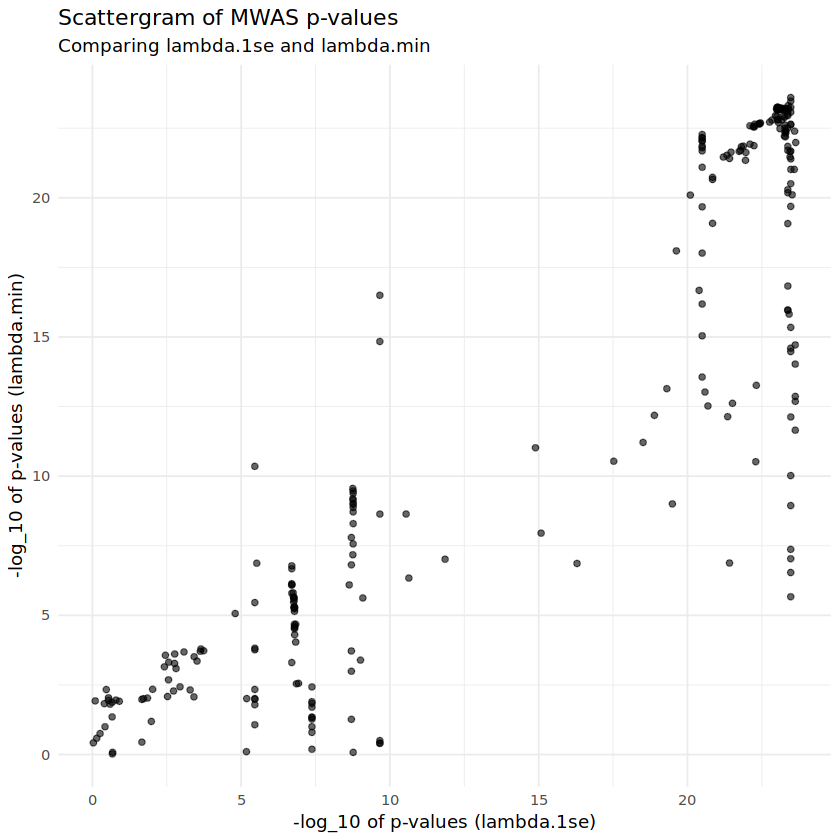

In [192]:
mwas.all.1se <- as.data.frame(mwas.all.1se)
mwas.all.min <- as.data.frame(mwas.all.min)

mwas.all.1se$pos <- rownames(mwas.all.1se)
mwas.all.min$pos <- rownames(mwas.all.min)

rownames(mwas.all.1se) <- rownames(mwas.all.min) <- NULL

colnames(mwas.all.1se)[2] <- "pval.lambda.1se"
colnames(mwas.all.min)[2] <- "pval.lambda.min"

df <- merge(mwas.all.1se, mwas.all.min, by = "pos")

ggplot(df, aes(x = -log(pval.lambda.1se, base = 10), y = -log(pval.lambda.min, base = 10))) +
  geom_point(alpha = 0.6) +
  labs(x = "-log_10 of p-values (lambda.1se)",
       y = "-log_10 of p-values (lambda.min)",
       title = "Scattergram of MWAS p-values",
       subtitle = "Comparing lambda.1se and lambda.min") +
  theme_minimal()

In [193]:
min(df$pval.lambda.1se)

[1] 2.297298e-24

In [194]:
min(df$pval.lambda.1se)

[1] 2.297298e-24

In [195]:
head(df)

,pos,z.x,pval.lambda.1se,z.y,pval.lambda.min
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,1980077,9.859725,6.221983e-23,9.940380,2.777657e-23
2,1980101,9.867943,5.732825e-23,9.936634,2.884077e-23
3,1980129,9.869397,5.650312e-23,9.943444,2.693496e-23
4,1980136,9.872536,5.476245e-23,9.960502,2.269133e-23
5,1980145,9.834843,7.969200e-23,9.947614,2.583008e-23
6,1980179,9.916470,3.530194e-23,9.970850,2.044717e-23


In [196]:
df$pos <- as.numeric(df$pos)

In [197]:
min(df$pval.lambda.1se)

[1] 2.297298e-24

In [198]:
min(df$pval.lambda.min)

[1] 2.509748e-24

In [199]:
library(ggplot2)
library(scales)  # For comma formatting

Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's colour values.”
Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's colour values.”


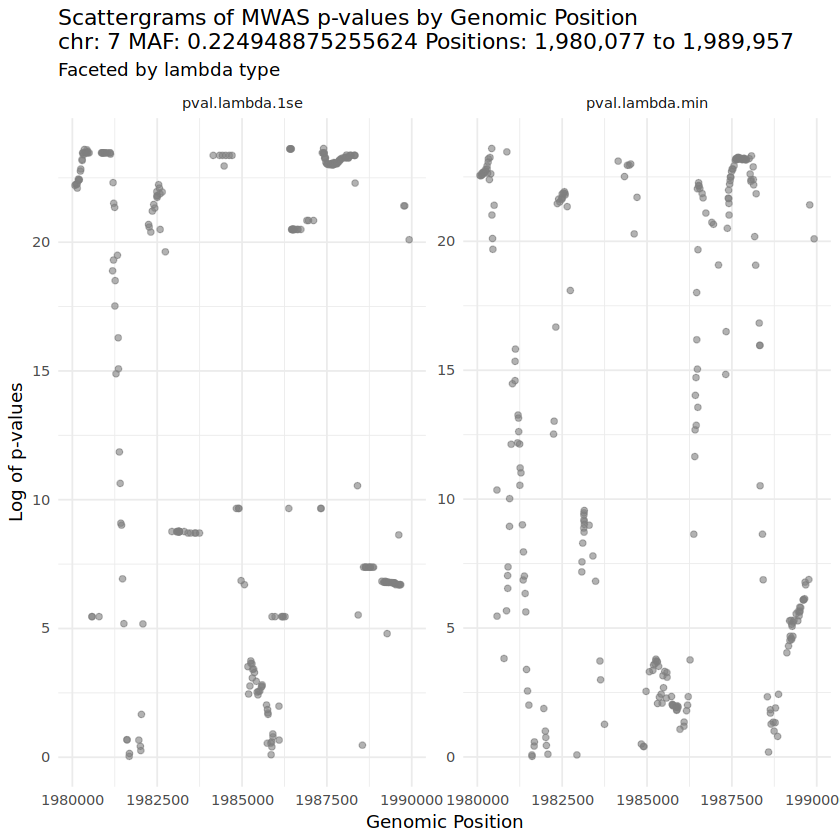

In [200]:
# Convert numbers to comma-separated format
formatted_min_pos <- comma(min_site_to_test_pos)
formatted_max_pos <- comma(max_site_to_test_pos)

# Converting the data to long format if not already done
df_long <- tidyr::pivot_longer(df, 
                               cols = c("pval.lambda.1se", "pval.lambda.min"), 
                               names_to = "variable", 
                               values_to = "pval")

# Plot with detailed title
ggplot(df_long, aes(x = pos, y = -log(pval, base = 10), color = variable)) +
  geom_point(alpha = 0.6) +
  labs(x = "Genomic Position",
       y = "Log of p-values",
       title = paste("Scattergrams of MWAS p-values by Genomic Position\nchr:", chr,
                     "MAF:", maf, 
                     "Positions:", formatted_min_pos, "to", formatted_max_pos),
       subtitle = "Faceted by lambda type") +
  scale_color_manual(values = c("lambda.1se" = "blue", "lambda.min" = "red")) +
  facet_wrap(~ variable, scales = "free_y") +
  theme_minimal()

### Plot Shizhong's old results to compare

In [201]:
library(data.table)
library(qqman)



For example usage please run: vignette('qqman')



Citation appreciated but not required:

Turner, (2018). qqman: an R package for visualizing GWAS results using Q-Q and manhattan plots. Journal of Open Source Software, 3(25), 731, https://doi.org/10.21105/joss.00731.





In [202]:
old <- fread("mwas.all.wind.10000")

In [203]:
head(old)

chr,pos_hg38,z,p
<chr>,<dbl>,<dbl>,<dbl>
chr1,1104982,0.8199803,0.4122274
chr1,1104984,0.8363752,0.4029439
chr1,1105038,0.7885519,0.4303740
chr1,1105092,0.7844246,0.4327910
chr1,1105200,0.8570140,0.3914372
chr1,1105299,0.7617538,0.4462070


In [204]:
colnames(old) <- c("CHR", "BP", "Z", "P")

In [205]:
old$CHR <- gsub("chr", "", old$CHR)
old$CHR <- as.numeric(old$CHR)

In [206]:
old$SNP <- paste0("Chr", old$CHR, ":", old$BP)

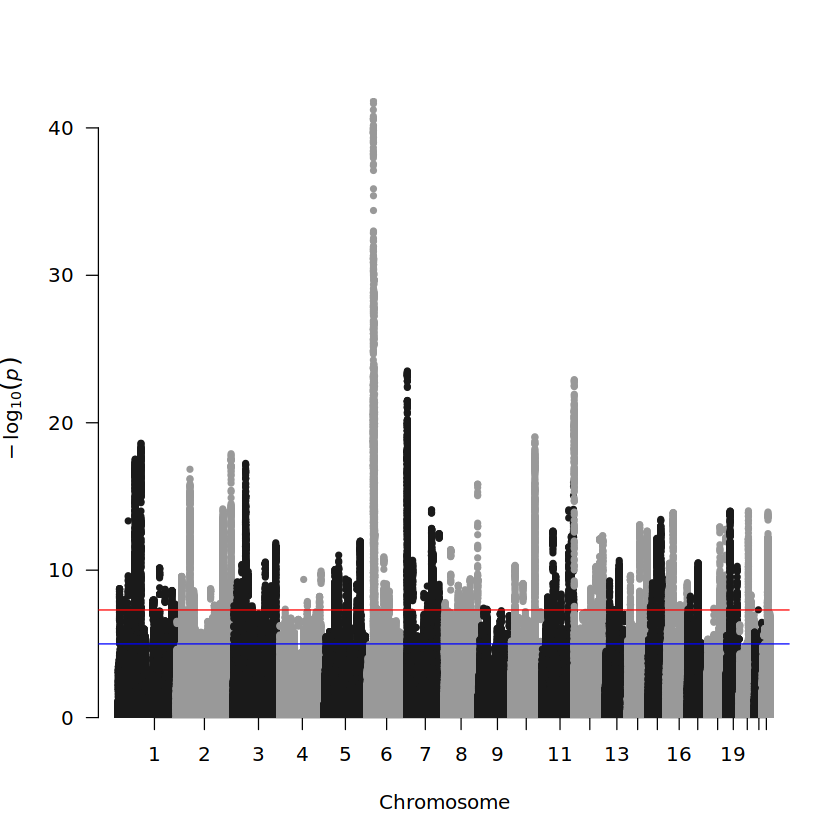

In [207]:
manhattan(old)

### Merging/overlap of Shizhong's results, ours.

In [208]:
head(old)

CHR,BP,Z,P,SNP
<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,1104982,0.8199803,0.4122274,Chr1:1104982
1,1104984,0.8363752,0.4029439,Chr1:1104984
1,1105038,0.7885519,0.4303740,Chr1:1105038
1,1105092,0.7844246,0.4327910,Chr1:1105092
1,1105200,0.8570140,0.3914372,Chr1:1105200
1,1105299,0.7617538,0.4462070,Chr1:1105299


In [209]:
head(models.all)

,features,coefs,cg
,<chr>,<dbl>,<dbl>
2,1975412,-0.0010587502,1980077
3,1980240,0.0023327672,1980077
4,1981269,-0.0004382277,1980077
5,1981360,0.0037984149,1980077
6,1987813,-0.0002457779,1980077
7,1989028,0.0026451759,1980077


In [210]:
head(df)

,pos,z.x,pval.lambda.1se,z.y,pval.lambda.min
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1980077,9.859725,6.221983e-23,9.940380,2.777657e-23
2,1980101,9.867943,5.732825e-23,9.936634,2.884077e-23
3,1980129,9.869397,5.650312e-23,9.943444,2.693496e-23
4,1980136,9.872536,5.476245e-23,9.960502,2.269133e-23
5,1980145,9.834843,7.969200e-23,9.947614,2.583008e-23
6,1980179,9.916470,3.530194e-23,9.970850,2.044717e-23


In [211]:
df$CHR <- 7

In [212]:
colnames(df)

[1] "pos"             "z.x"             "pval.lambda.1se" "z.y"            
[5] "pval.lambda.min" "CHR"

In [213]:
colnames(df)[1] <- "BP"

### What % of CpG sites in our results are also found in Shizhongs?

In [214]:
head(df)

,BP,z.x,pval.lambda.1se,z.y,pval.lambda.min,CHR
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1980077,9.859725,6.221983e-23,9.940380,2.777657e-23,7
2,1980101,9.867943,5.732825e-23,9.936634,2.884077e-23,7
3,1980129,9.869397,5.650312e-23,9.943444,2.693496e-23,7
4,1980136,9.872536,5.476245e-23,9.960502,2.269133e-23,7
5,1980145,9.834843,7.969200e-23,9.947614,2.583008e-23,7
6,1980179,9.916470,3.530194e-23,9.970850,2.044717e-23,7


In [215]:
colnames(df)[2] <- "Z_lambda.1se"
colnames(df)[4] <- "Z_lambda.min"

In [216]:
colnames(old)[3:4] <- c("Z_Shizhongs_old", "pval.shizhongs_old")

In [217]:
head(old)

CHR,BP,Z_Shizhongs_old,pval.shizhongs_old,SNP
<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,1104982,0.8199803,0.4122274,Chr1:1104982
1,1104984,0.8363752,0.4029439,Chr1:1104984
1,1105038,0.7885519,0.4303740,Chr1:1105038
1,1105092,0.7844246,0.4327910,Chr1:1105092
1,1105200,0.8570140,0.3914372,Chr1:1105200
1,1105299,0.7617538,0.4462070,Chr1:1105299


In [218]:
merged <- merge(old, df)

In [219]:
head(merged)

CHR,BP,Z_Shizhongs_old,pval.shizhongs_old,SNP,Z_lambda.1se,pval.lambda.1se,Z_lambda.min,pval.lambda.min
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
7,1987511,9.903333,4.026274e-23,Chr7:1987511,10.05045,9.144839e-24,9.998149,1.552721e-23
7,1987527,9.918049,3.474819e-23,Chr7:1987527,10.04821,9.355477e-24,9.995749,1.590797e-23
7,1987565,10.003180,1.475801e-23,Chr7:1987565,10.04297,9.865511e-24,10.025954,1.172222e-23
7,1987604,10.120719,4.471204e-24,Chr7:1987604,10.04759,9.413781e-24,10.074525,7.160591e-24
7,1987616,10.157135,3.079935e-24,Chr7:1987616,10.05271,8.937635e-24,10.088320,6.222540e-24
7,1987627,10.000170,1.521364e-23,Chr7:1987627,10.04725,9.446835e-24,10.083258,6.551719e-24


In [220]:
dim(old)

[1] 4525979       5

In [221]:
dim(df)

[1] 269   6

In [222]:
dim(merged)

[1] 28  9

In [223]:
length(setdiff(old$BP, df$BP))
#setdiff(old$BP, df$BP)

[1] 4472847

In [224]:
length(setdiff(df$BP, old$BP))
setdiff(df$BP, old$BP)

[1] 235

[1] 1980077 1980101 1980136 1980145 1980179 1980183 1980193 1980205 1980239
 [10] 1980247 1980287 1980291 1980303 1980320 1980326 1980355 1980373 1980396
 [19] 1980424 1980430 1980448 1980458 1980496 1980577 1980581 1980787 1980860
 [28] 1980869 1980893 1980896 1980905 1980948 1980952 1980997 1981035 1981111
 [37] 1981113 1981123 1981186 1981200 1981213 1981219 1981246 1981253 1981262
 [46] 1981286 1981328 1981352 1981359 1981386 1981410 1981427 1981449 1981479
 [55] 1981518 1981608 1981613 1981675 1981682 1981958 1982004 1982017 1982035
 [64] 1982079 1982246 1982264 1982311 1982357 1982397 1982428 1982488 1982495
 [73] 1982498 1982500 1982541 1982564 1982583 1982587 1982648 1982740 1982933
 [82] 1983077 1983083 1983105 1983135 1983139 1983141 1983143 1983145 1983149
 [91] 1983151 1983153 1983296 1983405 1983484 1983612 1983632 1983747 1984150
[100] 1984336 1984422 1984473 1984518 1984623 1984705 1984833 1984895 1984908
[109] 1984972 1985070 1985172 1985193 1985231 1985257 1985261 1985292 1985304
[118] 1985311 1985342 1985365 1985419 1985445 1985468 1985486 1985521 1985572
[127] 1985585 1985591 1985721 1985744 1985751 1985767 1985848 1985857 1985878
[136] 1985883 1985906 1985971 1986087 1986093 1986164 1986194 1986214 1986268
[145] 1986377 1986407 1986417 1986424 1986443 1986450 1986462 1986465 1986484
[154] 1986486 1986497 1986500 1986519 1986521 1986530 1986556 1986624 1986652
[163] 1986733 1986909 1986957 1987106 1987319 1987365 1987395 1987403 1987407
[172] 1987413 1987418 1987434 1987449 1987458 1987468 1987492 1988010 1988039
[181] 1988059 1988066 1988078 1988129 1988133 1988141 1988171 1988201 1988216
[190] 1988307 1988321 1988325 1988332 1988401 1988423 1988546 1988580 1988634
[199] 1988636 1988655 1988718 1988745 1988776 1988785 1988847 1988874 1989119
[208] 1989169 1989201 1989209 1989218 1989241 1989249 1989258 1989275 1989298
[217] 1989308 1989332 1989394 1989442 1989451 1989482 1989497 1989500 1989503
[226] 1989527 1989605 1989607 1989617 1989642 1989658 1989674 1989767 1989793
[235] 1989924

In [225]:
length(intersect(old$BP, df$BP))
intersect(old$BP, df$BP)

[1] 34

[1] 1980129 1987659 1985759 1987627 1989263 1987330 1987511 1987527 1987565
[10] 1987604 1987616 1987648 1987656 1987665 1987669 1987680 1987684 1987688
[19] 1987697 1987705 1987719 1987725 1987732 1987778 1987797 1987808 1987853
[28] 1987858 1987861 1987896 1987910 1987930 1985911 1985872

### Among those found in both, what is agreement?

In [226]:
head(merged)

CHR,BP,Z_Shizhongs_old,pval.shizhongs_old,SNP,Z_lambda.1se,pval.lambda.1se,Z_lambda.min,pval.lambda.min
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
7,1987511,9.903333,4.026274e-23,Chr7:1987511,10.05045,9.144839e-24,9.998149,1.552721e-23
7,1987527,9.918049,3.474819e-23,Chr7:1987527,10.04821,9.355477e-24,9.995749,1.590797e-23
7,1987565,10.003180,1.475801e-23,Chr7:1987565,10.04297,9.865511e-24,10.025954,1.172222e-23
7,1987604,10.120719,4.471204e-24,Chr7:1987604,10.04759,9.413781e-24,10.074525,7.160591e-24
7,1987616,10.157135,3.079935e-24,Chr7:1987616,10.05271,8.937635e-24,10.088320,6.222540e-24
7,1987627,10.000170,1.521364e-23,Chr7:1987627,10.04725,9.446835e-24,10.083258,6.551719e-24


In [227]:
library(dplyr)
library(tidyr)
library(ggplot2)

# Assuming 'merged' is your dataframe
# You may have already set the column names as shown in your previous message

# Convert BP to numeric if not already
merged$BP <- as.numeric(merged$BP)

# Convert p-values to their -log10 for visualization
merged$log_pval_shizhong <- -log10(merged$pval.shizhongs_old)
merged$log_pval_lambda_1se <- -log10(merged$pval.lambda.1se)
merged$log_pval_lambda_min <- -log10(merged$pval.lambda.min)



Attaching package: ‘dplyr’


The following object is masked from ‘package:bsseq’:

    combine


The following object is masked from ‘package:Biobase’:

    combine


The following object is masked from ‘package:matrixStats’:

    count


The following objects are masked from ‘package:GenomicRanges’:

    intersect, setdiff, union


The following object is masked from ‘package:GenomeInfoDb’:

    intersect


The following objects are masked from ‘package:IRanges’:

    collapse, desc, intersect, setdiff, slice, union


The following objects are masked from ‘package:S4Vectors’:

    first, intersect, rename, setdiff, setequal, union


The following objects are masked from ‘package:BiocGenerics’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, un

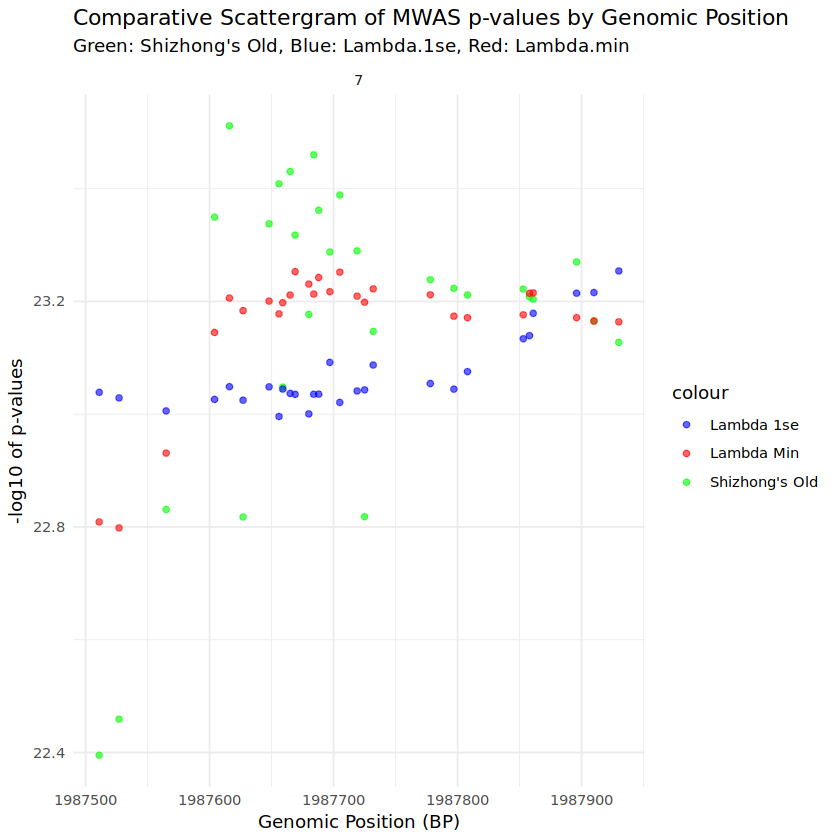

In [228]:
# Create the ggplot visualizations
plot <- ggplot(merged, aes(x = BP)) +
  geom_point(aes(y = log_pval_shizhong, color = "Shizhong's Old"), alpha = 0.6) +
  geom_point(aes(y = log_pval_lambda_1se, color = "Lambda 1se"), alpha = 0.6) +
  geom_point(aes(y = log_pval_lambda_min, color = "Lambda Min"), alpha = 0.6) +
  scale_color_manual(values = c("Shizhong's Old" = "green", "Lambda 1se" = "blue", "Lambda Min" = "red")) +
  labs(x = "Genomic Position (BP)",
       y = "-log10 of p-values",
       title = "Comparative Scattergram of MWAS p-values by Genomic Position",
       subtitle = "Green: Shizhong's Old, Blue: Lambda.1se, Red: Lambda.min") +
  theme_minimal() +
  facet_wrap(~ CHR, scales = "free_y")  # Facet by chromosome

# Print the plot
print(plot)


In [229]:
library(ggplot2)
library(tidyr)
library(scales)  # for comma formatting

# Define your positions
min_site_to_test_pos <- 73274305
max_site_to_test_pos <- 73420076

# Convert numbers to comma-separated format
formatted_min_pos <- scales::comma(min_site_to_test_pos)
formatted_max_pos <- scales::comma(max_site_to_test_pos)


In [230]:
# Ensure your dataframe 'df' is already properly formatted and 'pos' is correct
df_long <- tidyr::pivot_longer(df, 
                               cols = c("pval.lambda.1se", "pval.lambda.min"), 
                               names_to = "variable", 
                               values_to = "pval")


In [231]:
head(df_long)

BP,Z_lambda.1se,Z_lambda.min,CHR,variable,pval
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1980077,9.859725,9.940380,7,pval.lambda.1se,6.221983e-23
1980077,9.859725,9.940380,7,pval.lambda.min,2.777657e-23
1980101,9.867943,9.936634,7,pval.lambda.1se,5.732825e-23
1980101,9.867943,9.936634,7,pval.lambda.min,2.884077e-23
1980129,9.869397,9.943444,7,pval.lambda.1se,5.650312e-23
1980129,9.869397,9.943444,7,pval.lambda.min,2.693496e-23


In [232]:
library(tidyr)
library(ggplot2)
library(scales)  # for comma formatting

# Convert numbers to comma-separated format
formatted_min_pos <- comma(min_site_to_test_pos)
formatted_max_pos <- comma(max_site_to_test_pos)

# Convert the dataframe to long format including the new Shizhong's p-values
df_long <- pivot_longer(merged, 
                        cols = c("pval.lambda.1se", "pval.lambda.min", "pval.shizhongs_old"),
                        names_to = "variable",
                        values_to = "pval")


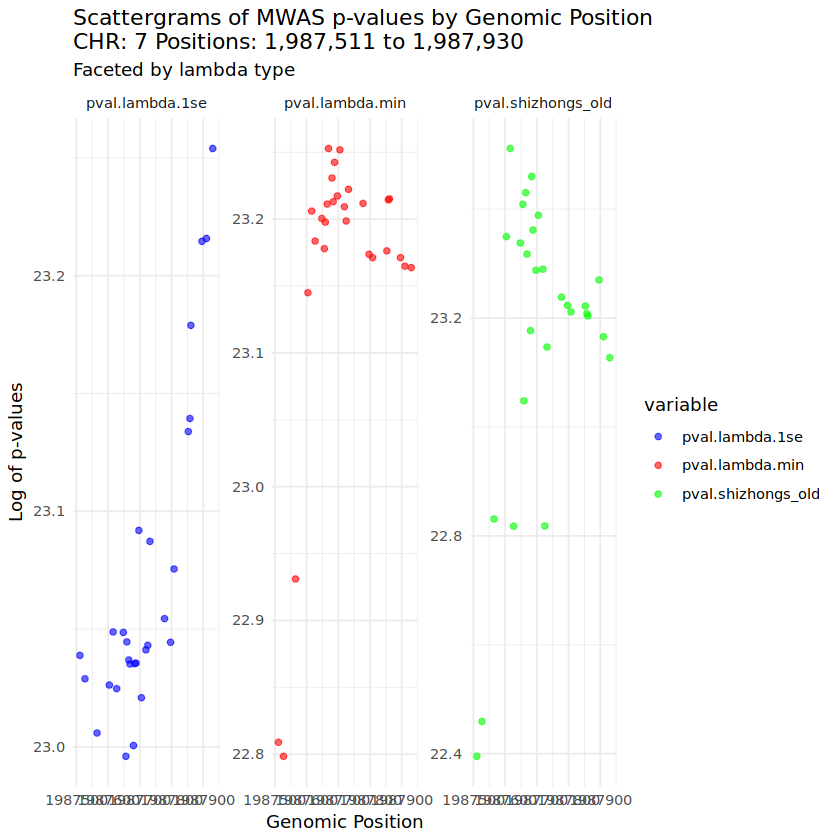

In [233]:
library(data.table)
library(ggplot2)
library(scales)
library(tidyr)

# Convert 'BP' to numeric
merged$BP <- as.numeric(merged$BP)

# Minimum p-values
min_pval_lambda.1se <- min(merged$pval.lambda.1se)
min_pval_lambda.min <- min(merged$pval.lambda.min)
min_pval_shizhongs_old <- min(merged$pval.shizhongs_old)

# Convert numbers to comma-separated format
formatted_min_pos <- comma(min(merged$BP))
formatted_max_pos <- comma(max(merged$BP))

# Convert data to long format
df_long <- pivot_longer(merged, cols = c("pval.lambda.1se", "pval.lambda.min", "pval.shizhongs_old"), 
                        names_to = "variable", values_to = "pval")

# Plot with detailed title
ggplot(df_long, aes(x = BP, y = -log10(pval), color = variable)) +
  geom_point(alpha = 0.6) +
  labs(x = "Genomic Position",
       y = "Log of p-values",
       title = paste("Scattergrams of MWAS p-values by Genomic Position\nCHR:", unique(merged$CHR),
                     "Positions:", formatted_min_pos, "to", formatted_max_pos),
       subtitle = "Faceted by lambda type") +
  scale_color_manual(values = c("pval.lambda.1se" = "blue", "pval.lambda.min" = "red", "pval.shizhongs_old" = "green")) +
  facet_wrap(~ variable, scales = "free_y") +
  theme_minimal()


In [234]:
Sys.time()

[1] "2024-08-07 08:09:12 PDT"

In [235]:
min(sites_to_test_pos)

[1] 1980077

In [236]:
max(sites_to_test_pos)

[1] 1989957

## Check these sites on chr 7

In [237]:
# Shizhong's original result

# chr7    1987910 10.1255085321387        4.25759742738181e-24
# chr7    1987896 10.1255085321387        4.25759742738189e-24
# chr7    1987797 10.0241523897721        1.19379483108027e-23
# chr7    1987778 10.0105851568856        1.36940148731912e-23

In [238]:
selected_pos <- c(1987910, 1987896, 1987797, 1987778)

In [239]:
head(merged)

CHR,BP,Z_Shizhongs_old,pval.shizhongs_old,SNP,Z_lambda.1se,pval.lambda.1se,Z_lambda.min,pval.lambda.min,log_pval_shizhong,log_pval_lambda_1se,log_pval_lambda_min
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
7,1987511,9.903333,4.026274e-23,Chr7:1987511,10.05045,9.144839e-24,9.998149,1.552721e-23,22.39510,23.03882,22.80891
7,1987527,9.918049,3.474819e-23,Chr7:1987527,10.04821,9.355477e-24,9.995749,1.590797e-23,22.45907,23.02893,22.79839
7,1987565,10.003180,1.475801e-23,Chr7:1987565,10.04297,9.865511e-24,10.025954,1.172222e-23,22.83097,23.00588,22.93099
7,1987604,10.120719,4.471204e-24,Chr7:1987604,10.04759,9.413781e-24,10.074525,7.160591e-24,23.34958,23.02624,23.14505
7,1987616,10.157135,3.079935e-24,Chr7:1987616,10.05271,8.937635e-24,10.088320,6.222540e-24,23.51146,23.04878,23.20603
7,1987627,10.000170,1.521364e-23,Chr7:1987627,10.04725,9.446835e-24,10.083258,6.551719e-24,22.81777,23.02471,23.18364


In [240]:
merged[which(merged$BP %in% selected_pos), ]

CHR,BP,Z_Shizhongs_old,pval.shizhongs_old,SNP,Z_lambda.1se,pval.lambda.1se,Z_lambda.min,pval.lambda.min,log_pval_shizhong,log_pval_lambda_1se,log_pval_lambda_min
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
7,1987778,10.09564,5.775168e-24,Chr7:1987778,10.05399,8.821927e-24,10.08962,6.140526e-24,23.23844,23.05444,23.21179
7,1987797,10.09222,5.980360e-24,Chr7:1987797,10.05171,9.028501e-24,10.08102,6.702985e-24,23.22327,23.04438,23.17373
7,1987896,10.10280,5.368717e-24,Chr7:1987896,10.09025,6.101489e-24,10.08045,6.741427e-24,23.27013,23.21456,23.17125
7,1987910,10.07924,6.824916e-24,Chr7:1987910,10.09052,6.084371e-24,10.07900,6.842050e-24,23.16590,23.21578,23.16481


In [241]:
# > min(p_values)
# [1] 1.299095e-59